# MLP displayed on Tensorboard

We have developed an MLP using tensorflow in another notebook. In this notebook, we'll add few lines of code to display the MLP network and a few parameters in tensorboard. First, we'll import dataset and configure a few simulation parameters.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("C:\\Users\Partha Acharjee\Desktop\Papers and works\Code\data", one_hot=True)


batchSize=100
maxIteration=int(mnist.train.images.shape[0]/batchSize)+1
total_epoch=15


imgSize=28
outputs=10

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting C:\Users\Partha Acharjee\Desktop\Papers and works\Code\data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting C:\Users\Partha Acharjee\Desktop\Papers and works\Code\data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting C:\Users\Partha Acharjee\Desktop\Papers and works\Code\data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting C:\Users\Partha Acharjee\Desktop\Papers and works\Code\data\t10k-labels-idx1-ubyte.gz


Now, we define the input and output node and give those a suitable name. We also define the number of layers and name for each layer.

In [2]:
# Three hidden layers, input and output layers
inputs=imgSize*imgSize
layers=[inputs,400,200,100,outputs]
layersname=['InputLayer','Hidden_1','Hidden_2','OutputLayer']

xnode=tf.placeholder(tf.float32,[None,inputs],name='ImageInput')
ynode=tf.placeholder(tf.float32,[None,outputs],name='TrueLevel')

Now, we define two functions to build the MLP. Note that we have added  tf.summary.histogram() for weights w and biases b. In the multiple_percepton, we define each layer inside the tf.name_scope(), and name is defined from the layer name.

In [4]:
def single_percepton(x,n_inputs,n_nurons,hidden='Yes'):
    w=tf.Variable(tf.random_normal([n_inputs,n_nurons]),name='W')
    b=tf.Variable(tf.random_normal([n_nurons]),name='b')
    activation=tf.add(tf.matmul(x,w),b)
    
    tf.summary.histogram("Weights", w)
    tf.summary.histogram("Biases", b)
    
    if hidden=='Yes': return tf.nn.relu(activation)
    else: return activation

def multiple_percepton(x,layers):
    l=[x]      
    for i in range(len(layers)-1):
        with tf.name_scope(layersname[i]):
            if(i<len(layers)-2): l.append(single_percepton(l[i],layers[i],layers[i+1]))
            else:l.append(single_percepton(l[i],layers[i],layers[i+1],hidden='No'))      
    return l[-1:]

Now, we are going to define the whole MLP(all layers and elements) inside MLP tf.name_scope(). We define the cost function inside cost tf.name_scope, and the accuracy calculation steps inside the accuracy tf.name_scope. This will keep our tensorflow graph clean.

In [6]:
with tf.name_scope("MLP"):
    outnode=multiple_percepton(xnode,layers)


with tf.name_scope("Cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=outnode, labels=ynode))
    optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
    
with tf.name_scope("Accuracy"):
    #Performance measure
    yestimate=tf.nn.softmax(outnode)
    yestimate=tf.argmax(yestimate,dimension=2)
    ytrue=tf.argmax(ynode,dimension=1)
    correct_prediction=tf.equal(ytrue,yestimate)
    accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

We also add two scalars in the tensorflow summary.

In [7]:
tf.summary.scalar("Cost_summary", cost)
tf.summary.scalar("Accuracy_summary", accuracy)

<tf.Tensor 'Accuracy_summary:0' shape=() dtype=string>

It's time to start the tensorflow session, initialize variables, define a writer to write the summary in specific location, and merge all summary to a single object.

In [8]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter("./logs/demoMLP", sess.graph)
allSummary = tf.summary.merge_all()

Let us see the accuracy on test dataset before training.

In [10]:
x_test=mnist.test.images
y_test=mnist.test.labels

c,acc=sess.run([cost,accuracy],feed_dict={xnode:x_test,ynode:y_test})
print("\n(Before training) Test accuracy:{0:1.2%} Test Cost: {1:.5}".format(acc,c))


(Before training) Test accuracy:12.90% Test Cost: 1.8356e+04


Now, we are going to train the MLP. We'll gather new summary data after each epoch.

In [11]:
costAll=[]
for epoch in range(total_epoch):
    for i in range(maxIteration):
        x_batch,y_batch=mnist.train.next_batch(batchSize)
        _,c=sess.run([optimizer,cost],feed_dict={xnode:x_batch,ynode:y_batch})
        costAll.append(c)
    print("Epoch: {0:2} Training Cost: {1:.5}".format(epoch+1,c))
    summary=sess.run(allSummary,feed_dict={xnode:x_batch,ynode:y_batch})
    writer.add_summary(summary, epoch)

Epoch:  1 Training Cost: 295.89
Epoch:  2 Training Cost: 221.84
Epoch:  3 Training Cost: 142.27
Epoch:  4 Training Cost: 65.853
Epoch:  5 Training Cost: 13.284
Epoch:  6 Training Cost: 71.78
Epoch:  7 Training Cost: 1.0727
Epoch:  8 Training Cost: 20.057
Epoch:  9 Training Cost: 41.771
Epoch: 10 Training Cost: 2.5499
Epoch: 11 Training Cost: 6.8786
Epoch: 12 Training Cost: 37.437
Epoch: 13 Training Cost: 0.0
Epoch: 14 Training Cost: 4.3919
Epoch: 15 Training Cost: 9.2602


In [22]:
c,acc=sess.run([cost,accuracy],feed_dict={xnode:x_test,ynode:y_test})
print("\n(After training) Test accuracy:{0:1.2%} Test Cost: {1:.5}".format(acc,c))


(After training) Test accuracy:94.34% Test Cost: 81.935


Now, let us plot a graph before looking at the tensorboard.

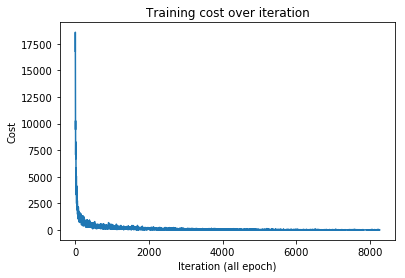

Run below command in commandline.
tensorboard --logdir=./logs/demoMLP
 Open the given address in browser.


In [12]:
plt.plot(costAll)
plt.xlabel('Iteration (all epoch)')
plt.ylabel('Cost')
plt.title('Training cost over iteration')
plt.show()    
    
print("Run below command in commandline.\ntensorboard --logdir=./logs/demoMLP\n Open the given address in browser.") 

When we run >>tensorboard --logdir=./logs/demoMLP in the python command window, it'll start a localhost and give the address to view the tensorboard. Here, a few snapshots are added from the tensorboard.

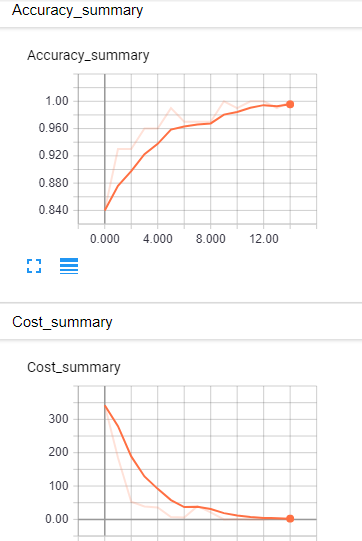

In [13]:
from IPython.display import Image
Image("images/accuracy _cost_MLP.png")

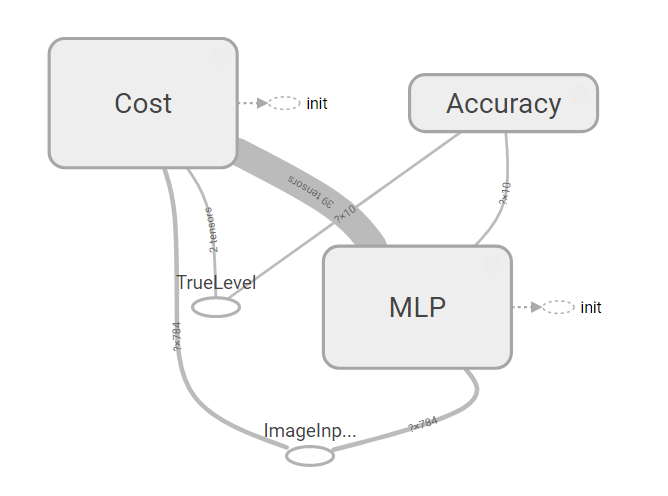

In [15]:
Image("images/Graph1.png")

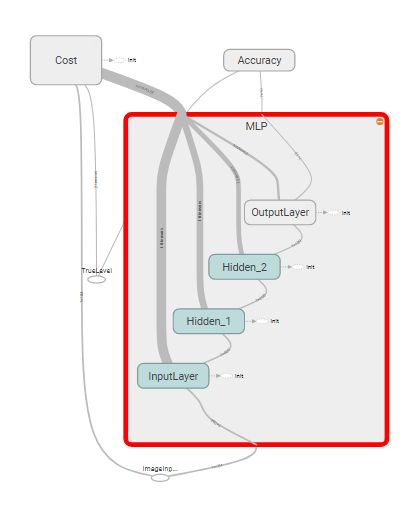

In [16]:
Image("images/Graph2.png")

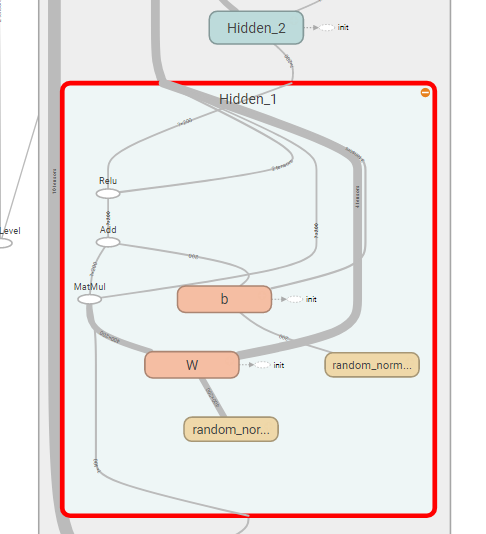

In [17]:
Image("images/Graph3.png")

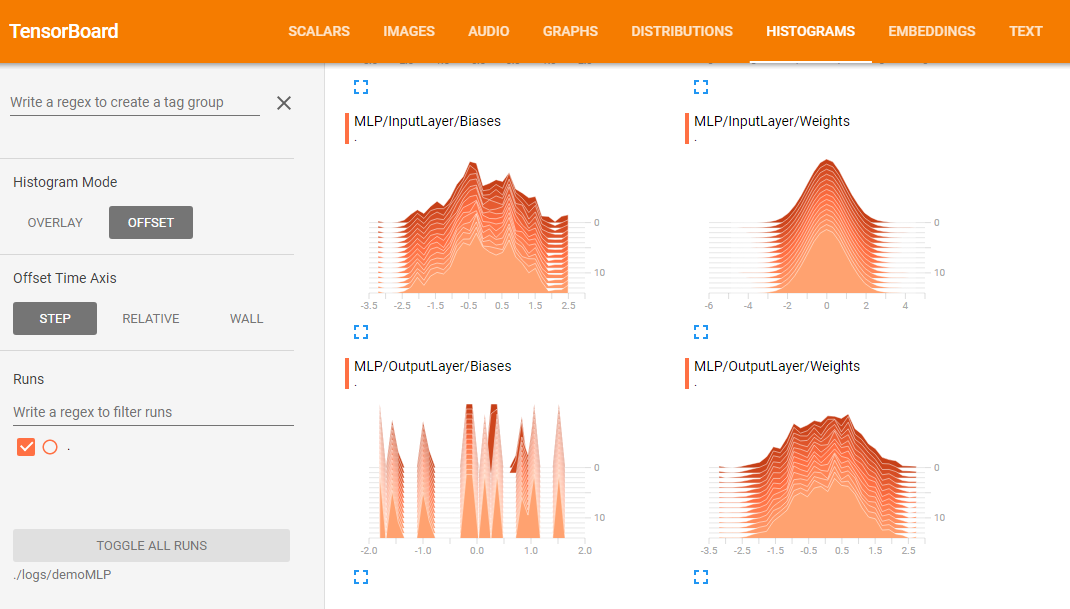

In [21]:
Image("images/weights.png")

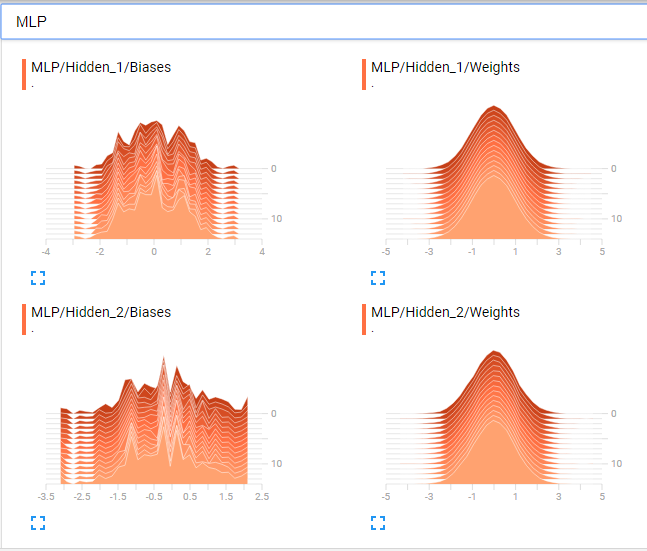

In [20]:
Image("images/parameters.png")

Thank you.